<a href="https://colab.research.google.com/github/kopalgarg/time_series_explainability/blob/master/wesad_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [341]:

import numpy as np
from numpy import array
from numpy import hstack
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import datetime
import torch
import torch.nn as nn
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta 
from sklearn.preprocessing import MinMaxScaler
import random
from scipy.io import arff
from sklearn.metrics import precision_score, roc_auc_score
from scipy.special import expit
from scipy.signal import butter, lfilter, freqz
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [342]:
if torch.cuda.is_available():
  device = "cuda"
else: device= "cpu"

device

'cpu'

In [343]:
df = pd.read_csv('swell_11.csv')
#Create date index
from datetime import datetime
df['date'] = pd.date_range(start='1/1/2020', periods=len(df), freq='D')
date_time = pd.to_datetime(df.pop('date'), format='%d.%m.%Y')
df=df.drop(['Unnamed: 0', 'subject id', 'SSSQ'], axis=1)
#df = df[['HR','RMSSD', 'LF', 'HF','condition']]

df.shape

(2789, 5)

In [344]:
#scaler = MinMaxScaler()
#dfn = df
#dfn[dfn.columns.difference(['condition'])] = scaler.fit_transform(dfn[dfn.columns.difference(['condition'])])

from sklearn.model_selection import train_test_split

test_ratio = 0.2

y = df['condition']
X=df.drop(['condition'], axis=1)

val_ratio = test_ratio / (1 - test_ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)

In [346]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_arr = scaler.fit_transform(X_train)
X_test_arr = scaler.transform(X_test)
X_val = scaler.transform(X_val)

y_train_arr = y_train.to_numpy()
y_val_arr = y_val.to_numpy()
y_test_arr = y_test.to_numpy()

In [347]:
X_test_arr.shape

(558, 4)

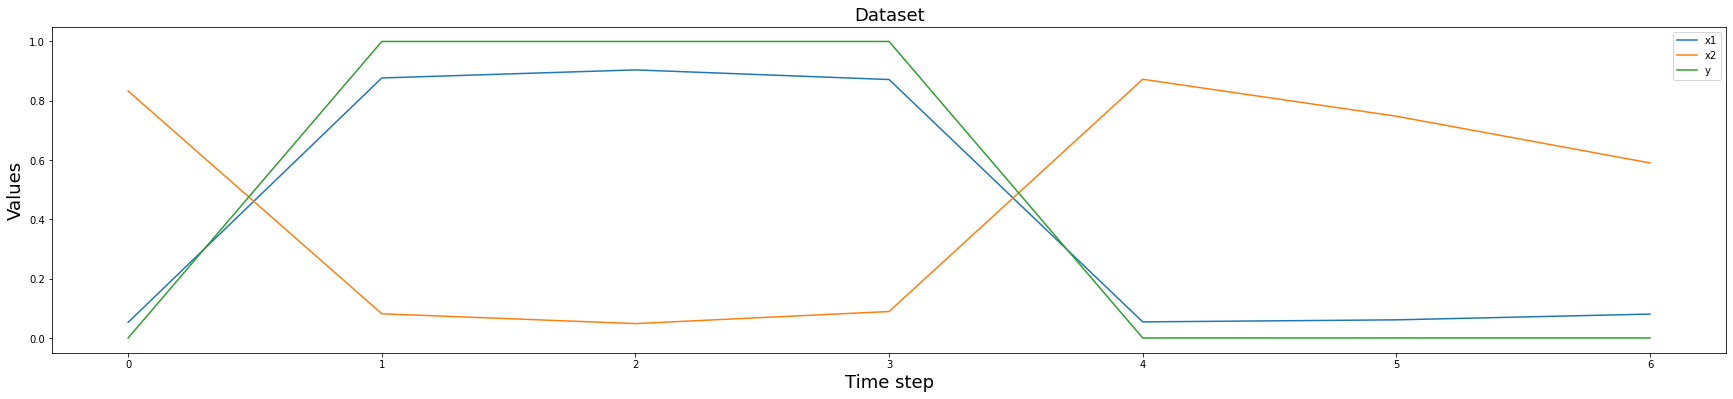

In [348]:
x_1 = X_train_arr[0:7,0]
x_2 = X_train_arr[0:7,1]
y = y_train_arr[0:7]
plt.figure(figsize=(30, 6))
plt.plot(x_1[:7] , label='x1')
plt.plot(x_2[:7] , label='x2')
plt.plot(y[:7] , label='y')
plt.legend(loc='upper right')
plt.title("Dataset" ,  fontsize=18)
plt.xlabel('Time step' ,  fontsize=18)
plt.ylabel('Values' , fontsize=18)
plt.legend()
plt.show()

In [355]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 24

train_features = torch.Tensor(X_train_r)
train_targets = torch.Tensor(y_train_r)
val_features = torch.Tensor(X_val_r)
val_targets = torch.Tensor(y_val_r)
test_features = torch.Tensor(X_test_r)
test_targets = torch.Tensor(y_test_r)


train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [390]:

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim,device=x.device).requires_grad_()
        h0.to(device)
        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim,device=x.device).requires_grad_()
        c0.to(device)
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [357]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim,device=x.device).requires_grad_()
        h0.to(device)
        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [358]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim,device=x.device).requires_grad_()
        h0.to(device)

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [359]:
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

In [360]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)
        yhat.to(device)
        # Computes loss
        loss = self.loss_fn(y, yhat)
        loss.to(device)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()
    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        model_path = f'{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'
        if torch.cuda.is_available():
          device = "cuda"
        else: device= "cpu"
        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(self.model.state_dict(), model_path)


    def evaluate(self, test_loader, batch_size=1, n_features=1):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to('cpu').detach().numpy())
                values.append(y_test.to('cpu').detach().numpy())

        return predictions, values
    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([24, 1])) that is different to the input size (torch.Size([24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1/50] Training loss: 0.6045	 Validation loss: 0.4992
[2/50] Training loss: 0.3573	 Validation loss: 0.2600
[3/50] Training loss: 0.2548	 Validation loss: 0.2509
[4/50] Training loss: 0.2544	 Validation loss: 0.2507
[5/50] Training loss: 0.2536	 Validation loss: 0.2507
[6/50] Training loss: 0.2534	 Validation loss: 0.2505
[7/50] Training loss: 0.2527	 Validation loss: 0.2502
[8/50] Training loss: 0.2527	 Validation loss: 0.2504
[9/50] Training loss: 0.2524	 Validation loss: 0.2502
[10/50] Training loss: 0.2525	 Validation loss: 0.2502
[50/50] Training loss: 0.2502	 Validation loss: 0.2500


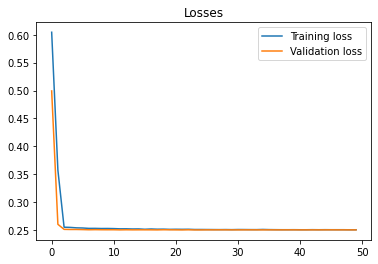

In [417]:
import torch.optim as optim

input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = len(X_train.columns)*2
layer_dim = 3
batch_size = 24
dropout = 0.2
n_epochs = 50
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = get_model('lstm', model_params)

loss_fn = nn.MSELoss(reduction="mean")
loss_fn.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model.to(device), loss_fn=loss_fn.to(device), optimizer=optimizer)

opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)

opt.plot_losses()

In [418]:
predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [419]:
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"condition": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    #df_result = inverse_transform(scaler, df_result, [["condition", "prediction"]])
    return df_result


df_result = format_predictions(predictions, values, X_test, scaler)

In [404]:
#df_result.loc[df_result['prediction'] >= 0.9, 'prediction'] = 1
#df_result.loc[df_result['prediction'] < 0.9, 'prediction'] = 0

# TODO - Sigmoid nn

In [420]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(df):
    return {'mae' : mean_absolute_error(df.condition, df.prediction),
            'rmse' : mean_squared_error(df.condition, df.prediction) ** 0.5,
            'r2' : r2_score(df.condition, df.prediction)}

result_metrics = calculate_metrics(df_result)
result_metrics

{'mae': 0.49048033, 'r2': 0.033170536667976425, 'rmse': 0.49055153059751244}

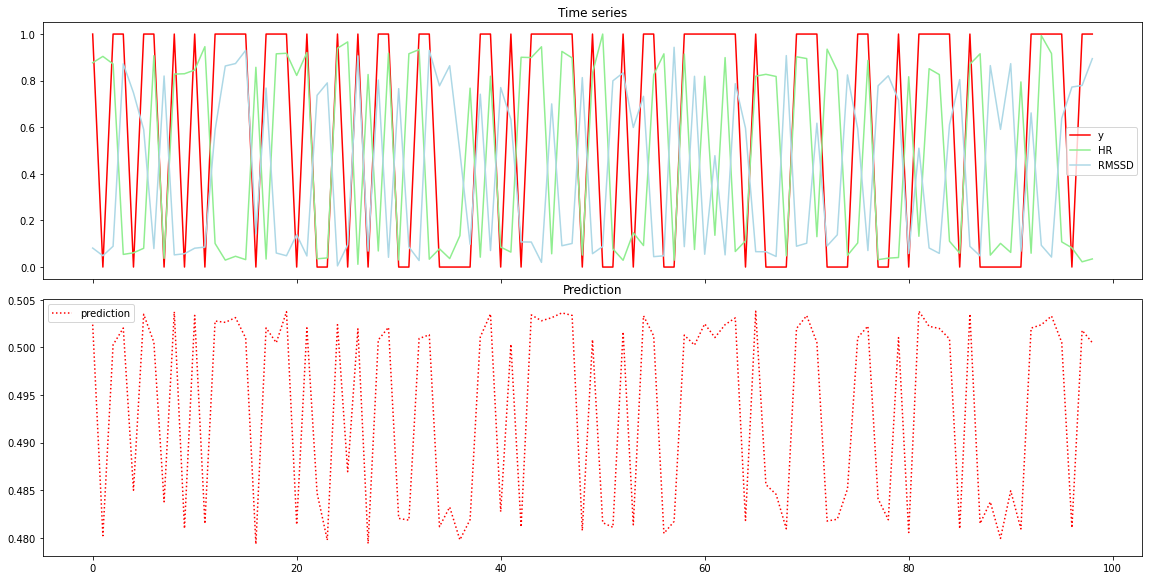

In [421]:
f, (ax1, ax2) = plt.subplots(2, 1 ,sharex='col')
f.set_figheight(8)
f.set_figwidth(16)
f.tight_layout()

ax2.plot(df_result['prediction'][1:100,].values, color = 'red', linestyle = 'dotted',  label='prediction')
ax2.set_title('Prediction')
ax1.plot(df_result['condition'][1:100,].values, color = 'red', label = 'y')
ax1.plot(X_train_arr[1:100,0], color ='lightgreen',label ='HR')
ax1.plot(X_train_arr[1:100,1], color = 'lightblue',label ='RMSSD')
ax1.set_title('Time series')
ax1.legend();
ax2.legend();

In [446]:
class FITExplainer:
    def __init__(self, model, generator=None,activation=torch.nn.Softmax(-1),n_classes=2):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.generator = generator
        self.base_model = model.to(self.device)
        self.activation = activation
        self.n_classes=n_classes

    def fit_generator(self, generator_model, train_loader, test_loader, n_epochs=300,cv=0):
        train_joint_feature_generator(generator_model, train_loader, test_loader, generator_type='joint_generator',
                                      n_epochs=300, lr=0.001, weight_decay=0,cv=cv)
        self.generator = generator_model.to(self.device)

    def attribute(self, x, n_samples=10, retrospective=False, distance_metric='kl',subsets=None):
        """
        Compute importance score for a sample x, over time and features
        :param x: Sample instance to evaluate score for. Shape:[batch, features, time]
        :param n_samples: number of Monte-Carlo samples
        :return: Importance score matrix of shape:[batch, features, time]
        """
        self.generator.eval()
        self.generator.to(self.device)
        x = x.to(self.device)
        _, t_len, n_features = x.shape
        score = np.zeros(list(x.shape))
        if retrospective:
            p_y_t = self.activation(self.base_model(x))

        for t in range(1, t_len):
            if not retrospective:
                p_y_t = self.activation(self.base_model(x[:, :t+1, :]))
                p_tm1 = self.activation(self.base_model(x[:,0:t,:]))

            for i in range(n_features):
                x_hat = x[:,0:t+1,:].clone()
                div_all=[]
                t1_all=[]
                t2_all=[]
                for _ in range(n_samples):
                    x_hat_t, _ = self.generator.forward_conditional(x[:, :t, :], x[:, t, :], [i])
                    x_hat[:, t, :] = x_hat_t
                    y_hat_t = self.activation(self.base_model(x_hat))
                    if distance_metric == 'kl':
                        if type(self.activation).__name__==type(torch.nn.Softmax(-1)).__name__:
                            div = torch.sum(torch.nn.KLDivLoss(reduction='none')(torch.log(p_tm1), p_y_t), -1) - \
                             torch.sum(torch.nn.KLDivLoss(reduction='none')(torch.log(y_hat_t), p_y_t), -1)
                            lhs = torch.sum(torch.nn.KLDivLoss(reduction='none')(torch.log(p_tm1), p_y_t), -1)
                            rhs = torch.sum(torch.nn.KLDivLoss(reduction='none')(torch.log(y_hat_t), p_y_t), -1)
                            # div = torch.where(rhs>lhs, torch.zeros(rhs.shape), rhs/lhs)
                        else:
                            t1 = kl_multilabel(p_y_t, p_tm1)
                            t2 = kl_multilabel(p_y_t, y_hat_t)
                            div,_ = torch.max(t1 - t2,dim=1)
                            #div = div[:,0] #flatten
                        div_all.append(div.cpu().detach().numpy())
                    elif distance_metric == 'mean_divergence':
                        div = torch.abs(y_hat_t - p_y_t)
                        div_all.append(np.mean(div.detach().cpu().numpy(), -1))
                    elif distance_metric=='LHS':
                        div = torch.sum(torch.nn.KLDivLoss(reduction='none')(torch.log(p_tm1), p_y_t), -1)
                        div_all.append(div.cpu().detach().numpy())
                    elif distance_metric=='RHS':
                        div = torch.sum(torch.nn.KLDivLoss(reduction='none')(torch.log(y_hat_t), p_y_t), -1)
                        div_all.append(div.cpu().detach().numpy())
                E_div = np.mean(np.array(div_all),axis=0)
                if distance_metric =='kl':
                    # score[:, i, t] = E_div
                    score[:, t, i] = 2./(1+np.exp(-5*E_div)) - 1
                    print(score[:, t, i])
                elif distance_metric=='mean_divergence':
                    score[:, t, i] = 1-E_div
                else:
                    score[:, t, i] = E_div
        return score

In [493]:
class AFOExplainer:
    def __init__(self, model, train_loader,activation=torch.nn.Softmax(-1)):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.base_model = model.to(self.device)
        trainset = list(train_loader.dataset)
        self.data_distribution = torch.stack([x[0] for x in trainset])
        self.activation = activation

    def attribute(self, x, retrospective=False):
        """
        Compute importance score for a sample x, over time and features
        :param x: Sample instance to evaluate score for. Shape:[batch, features, time]
        :param n_samples: number of Monte-Carlo samples
        :return: Importance score matrix of shape:[batch, features, time]
        """
        x = x.to(self.device)
        _, t_len, n_features = x.shape
        score = np.zeros(x.shape)
        if retrospective:
            p_y_t = self.activation(self.base_model(x))

        for t in range(1, t_len):
            if not retrospective:
                p_y_t = self.activation(self.base_model(x[:, :t + 1,:]))
            for i in range(n_features):
                feature_dist = (np.array(self.data_distribution[:,:, i]).reshape(-1))
                x_hat = x[:,0:t+1,:].clone()
                kl_all=[]
                for _ in range(10):
                    x_hat[:, t, i] = torch.Tensor(np.random.choice(feature_dist, size=(len(x),))).to(self.device)
                    y_hat_t = self.activation(self.base_model(x_hat))
                    # kl = torch.nn.KLDivLoss(reduction='none')(torch.log(y_hat_t), p_y_t)
                    kl = torch.abs((y_hat_t[:, :]) - (p_y_t[:, :]))
                    # kl_all.append(torch.sum(kl, -1).cpu().detach().numpy())
                    kl_all.append(np.mean(kl.detach().cpu().numpy(), -1))
                E_kl = np.mean(np.array(kl_all), axis=0)
                # score[:, i, t] = 2./(1+np.exp(-1*E_kl)) - 1.
                score[:, t, i] = E_kl
        return score

In [447]:
class JointFeatureGenerator(torch.nn.Module):
    def __init__(self, feature_size, latent_size=100, prediction_size=1, seed=random.seed('2019'), **kwargs):
        """ Conditional generator model to predict future observations
        :param feature_size: Number of features in the input
        :param hist: (boolean) If True, use previous observations in the time series to generate next observation.
                            If False, generate the sample given other dimensions at that time point
        :param hidden_size: Size of hidden units for the recurrent structure
        :param prediction_size: Number of time steps to generate
        :param conditional: (boolean) If True, use both other observations at time t as well as the history to
                            generate future observations
        :param seed: Random seed
        """
        super(JointFeatureGenerator, self).__init__()
        self.seed = seed
        self.feature_size = feature_size
        self.hidden_size = feature_size*2
        self.latent_size = latent_size
        self.prediction_size = prediction_size
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        non_lin = kwargs["non_linearity"] if "non_linearity" in kwargs.keys() else torch.nn.Tanh()
        self.data=kwargs['data'] if 'data' in kwargs.keys() else 'mimic'
        self.diag = kwargs['diag'] if 'diag' in kwargs.keys() else False

        # Generates the parameters of the distribution
        self.rnn = torch.nn.GRU(self.feature_size, self.hidden_size)
        for layer_p in self.rnn._all_weights:
            for p in layer_p:
                if 'weight' in p:
                    torch.nn.init.normal(self.rnn.__getattr__(p), 0.0, 0.02)

        if self.data=='mimic' or self.data=='ghg' or self.data=='mimic_int':
            self.dist_predictor = torch.nn.Sequential(torch.nn.Linear(self.hidden_size, 100),
                                                 non_lin,
                                                 torch.nn.BatchNorm1d(num_features=100),
                                                 #torch.nn.Dropout(0.5),
                                                 torch.nn.Linear(100, self.latent_size*2))
        else:
            self.dist_predictor = torch.nn.Sequential(torch.nn.Linear(self.hidden_size, 10),
                                                 non_lin,
                                                 torch.nn.BatchNorm1d(num_features=10),
                                                 #torch.nn.Dropout(0.5),
                                                 torch.nn.Linear(10, self.latent_size*2), non_lin)

        if not self.diag:
            self.cov_generator = torch.nn.Sequential(torch.nn.Linear(self.latent_size, 10),#+self.hidden_size, 100),
                                                 non_lin,
                                                 torch.nn.BatchNorm1d(num_features=10),
                                                 torch.nn.Linear(10, self.feature_size*self.feature_size),torch.nn.ReLU())
        else:
            self.cov_generator = torch.nn.Sequential(torch.nn.Linear(self.latent_size, 10),#+self.hidden_size, 100),
                                                 non_lin,
                                                 torch.nn.BatchNorm1d(num_features=10),
                                                 torch.nn.Linear(10, self.feature_size),torch.nn.ReLU())
        self.mean_generator = torch.nn.Sequential(torch.nn.Linear(self.latent_size, 10),#+self.hidden_size, 100),
                                                 non_lin,
                                                 torch.nn.BatchNorm1d(num_features=10),
                                                 torch.nn.Linear(10, self.feature_size))

    def forward(self, x, past, sig_ind, method):
        """
        Sample full observation at t, given past information
        :param x: observation at time t
        :param past: All observations upto time t
        :param sig_ind: Index of the feature to investigate
        :param cond_one: Determines the conditioning method. If True, the joint distribution will be conditioned on only
                        a single feature, otherwise it will be conditioned on all variables except one
        :return: full sample at time t
        """
        mean, covariance = self.likelihood_distribution(past)  # P(X_t|X_0:t-1)
        if len(x.shape) is 1:
            x = x.unsqueeze(0)
        if method=='c1':  # c1 method: P(x_{-i,t}|X_{0:t-1}, x_{i,t})
            x_ind = x[:, sig_ind].to(self.device).unsqueeze(-1)
            mean_1 = torch.cat((mean[:, :sig_ind], mean[:, sig_ind + 1:]), 1).unsqueeze(-1)
            cov_1_2 = torch.cat(([covariance[:, 0:sig_ind, sig_ind], covariance[:, sig_ind + 1:, sig_ind]]),
                                1).unsqueeze(-1)
            cov_2_2 = covariance[:, sig_ind, sig_ind]
            cov_1_1 = torch.cat(([covariance[:, 0:sig_ind, :], covariance[:, sig_ind + 1:, :]]), 1)
            cov_1_1 = torch.cat(([cov_1_1[:, :, 0:sig_ind], cov_1_1[:, :, sig_ind + 1:]]), 2)
            mean_cond = mean_1 + torch.bmm(cov_1_2, (x_ind - mean[:, sig_ind]).unsqueeze(-1)) / cov_2_2
            covariance_cond = cov_1_1 - torch.bmm(cov_1_2, torch.transpose(cov_1_2, 2, 1)) / cov_2_2
            likelihood = torch.distributions.multivariate_normal.MultivariateNormal(loc=mean_cond.squeeze(-1),
                                                                               covariance_matrix=covariance_cond)
            sample = likelihood.rsample()
            full_sample = torch.cat([sample[:,0:sig_ind], x_ind, sample[:,sig_ind:]], 1)
            return full_sample, mean[:,sig_ind]
        elif method=='m1':  # m1 method: marginalize over x_{-i,t}
            known_signal = torch.cat((x[:, :sig_ind], x[:, sig_ind + 1:]), 1).to(self.device)
            return torch.cat((known_signal[:, 0:sig_ind], mean[:,sig_ind].unsqueeze(-1), known_signal[:, sig_ind:]), 1), mean[:,sig_ind]
        elif method=='inform':
            return torch.cat((mean[:,:sig_ind], x[:, sig_ind].unsqueeze(-1), mean[:,sig_ind+1:]), 1), mean[:,sig_ind]
        elif method=='c2':  # c2 method: P(x_{i,t}|X_{0:t-1}, x_{-i,t})
            x = torch.cat((x[:, :sig_ind], x[:, sig_ind + 1:]), 1).to(self.device)
            margianl_cov = torch.cat(([covariance[:, :, 0:sig_ind], covariance[:, :, sig_ind + 1:]]), 2)
            margianl_cov = torch.cat(([margianl_cov[:, 0:sig_ind, :], margianl_cov[:, sig_ind + 1:, :]]), 1)
            cov_i_i = torch.cat((covariance[:, sig_ind, :sig_ind], covariance[:, sig_ind, sig_ind + 1:]), 1).view(len(covariance), 1, -1)
            mean_i = torch.cat((mean[:, :sig_ind], mean[:, sig_ind + 1:]), 1)
            mean_cond = mean[:, sig_ind] + torch.bmm(torch.bmm(cov_i_i, torch.inverse(margianl_cov)),
                                                     (x - mean_i).unsqueeze(-1))
            covariance_cond = covariance[:, sig_ind, sig_ind] - torch.bmm(torch.bmm(cov_i_i, torch.inverse(margianl_cov)),
                                                                          torch.transpose(cov_i_i, 1, 2))
            likelihood = torch.distributions.multivariate_normal.MultivariateNormal(loc=mean_cond,
                                                                                    covariance_matrix=covariance_cond)
            sample = likelihood.rsample()
            full_sample = torch.cat([x[:, 0:sig_ind], sample[0], x[:, sig_ind:]], 1)
            return full_sample, mean[:,sig_ind]

    def likelihood_distribution(self, past):
        past = past.permute(2, 0, 1)
        all_encoding, encoding = self.rnn(past.to(self.device))
        H = encoding.view(encoding.size(1),-1)
        # Find the distribution of the latent variable Z
        mu_std = self.dist_predictor(H)
        mu = mu_std[:,:mu_std.shape[1]//2]
        std = mu_std[:, mu_std.shape[1]//2:]
        # sample Z from the distribution
        Z = mu + std*torch.randn_like(mu).to(self.device)
        # Z_H = torch.cat((Z, H), 1)
        # Generate the distribution P(X|H,Z)
        mean = self.mean_generator(Z)
        cov_noise = (torch.eye(self.feature_size).unsqueeze(0).repeat(len(Z), 1, 1) * 1e-5).to(self.device)
        if not self.diag:
            A = self.cov_generator(Z).view(-1, self.feature_size, self.feature_size)
            covariance = torch.bmm(A, torch.transpose(A, 1, 2)) + cov_noise
        else:
            A = self.cov_generator(Z).view(-1, self.feature_size)
            covariance = torch.diag_embed(A**2) + cov_noise
        return mean, covariance

    def forward_joint(self, past):
        mean, covariance = self.likelihood_distribution(past)
        likelihood = torch.distributions.multivariate_normal.MultivariateNormal(loc=mean, covariance_matrix=covariance)
        return likelihood.rsample()

    def forward_conditional(self, past, current, sig_inds):
        if current.shape[-1]==len(sig_inds):
            return current, current
        past = past.to(self.device)
        current = current.to(self.device)
        if len(current.shape) is 1:
            current = current.unsqueeze(0)
        mean, covariance = self.likelihood_distribution(past)  # P(X_t|X_0:t-1)
        sig_inds_comp = list(set(range(past.shape[-2]))-set(sig_inds))
        ind_len = len(sig_inds)
        ind_len_not = len(sig_inds_comp)
        x_ind = current[:, sig_inds].view(-1,ind_len)
        mean_1 = mean[:, sig_inds_comp].view(-1,ind_len_not)
        cov_1_2 = covariance[:, sig_inds_comp, :][:,:,sig_inds].view(-1,ind_len_not, ind_len)
        cov_2_2 = covariance[:, sig_inds, :][:,:,sig_inds].view(-1,ind_len, ind_len)
        cov_1_1 = covariance[:, sig_inds_comp, :][:,:,sig_inds_comp].view(-1,ind_len_not, ind_len_not)
        mean_cond = mean_1 + torch.bmm( (torch.bmm(cov_1_2, torch.inverse(cov_2_2))), (x_ind - mean[:, sig_inds]).view(-1,ind_len,1)).squeeze(-1)
        covariance_cond = cov_1_1 - torch.bmm( torch.bmm(cov_1_2, torch.inverse(cov_2_2)), torch.transpose(cov_1_2, 2, 1) )

        # P(x_{-i,t}|x_{i,t})
        likelihood = MultivariateNormal(loc=mean_cond.squeeze(-1), covariance_matrix=covariance_cond)
        sample = likelihood.rsample()
        full_sample = current.clone()
        full_sample[:,sig_inds_comp] = sample
        return full_sample, mean[:,sig_inds_comp]


In [494]:
generator = JointFeatureGenerator(feature_size = len(X_train.columns))
explainer = AFOExplainer(model, train_loader =train_loader,activation=torch.nn.Sigmoid())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


In [501]:
importance_scores = []
ranked_feats=[]
n_samples = 10
data = ''

import time

In [502]:
for x,y in test_loader:
  model.train()
  model.to(device)
  x = x.to(device)
  score = explainer.attribute(x)
  ranked_features = np.array([((-(score[n])).argsort(0).argsort(0) + 1) \
                                    for n in range(x.shape[0])])
  importance_scores.append(score)
  ranked_feats.append(ranked_features)
  

In [505]:
importance_scores = np.concatenate(importance_scores, 0)
importance_scores

array([[[0., 0., 0., 0.]],

       [[0., 0., 0., 0.]],

       [[0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0.]],

       [[0., 0., 0., 0.]],

       [[0., 0., 0., 0.]]])

In [506]:
ranked_feats = np.concatenate(ranked_feats,0)
ranked_feats

array([[[1, 1, 1, 1]],

       [[1, 1, 1, 1]],

       [[1, 1, 1, 1]],

       ...,

       [[1, 1, 1, 1]],

       [[1, 1, 1, 1]],

       [[1, 1, 1, 1]]])

In [ ]:
# alternatively

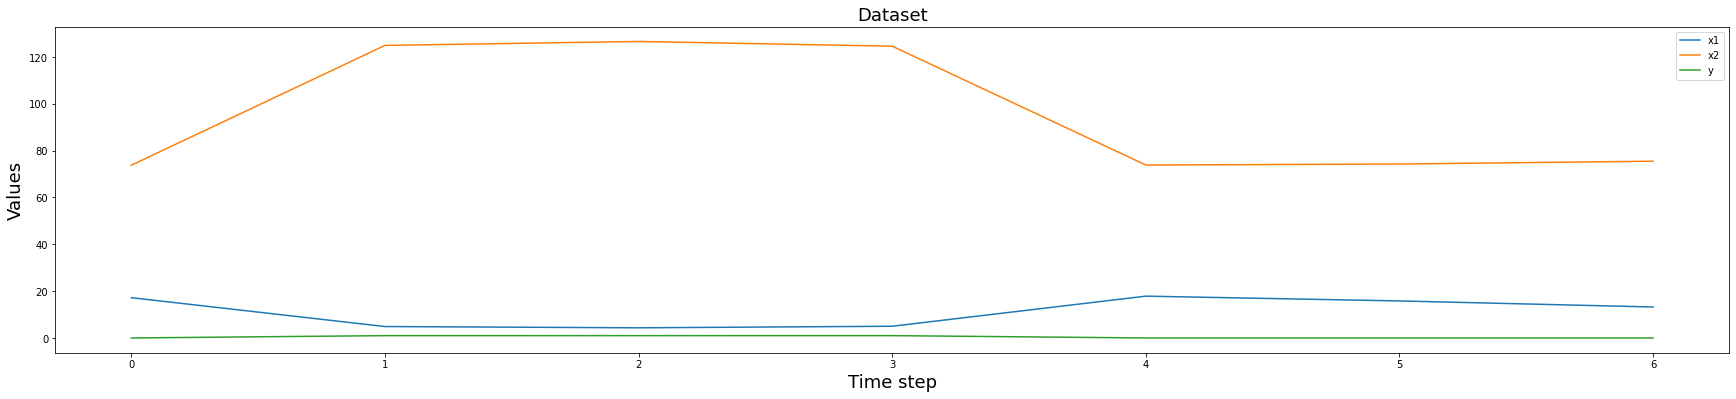

In [109]:
x_1 = df['RMSSD']
x_2 = df['HR']
y = df['condition']
x_1 = x_1.values
x_2 = x_2.values
y = y.values
plt.figure(figsize=(30, 6))
plt.plot(x_1[:7] , label='x1')
plt.plot(x_2[:7] , label='x2')
plt.plot(y[:7] , label='y')
plt.legend(loc='upper right')
plt.title("Dataset" ,  fontsize=18)
plt.xlabel('Time step' ,  fontsize=18)
plt.ylabel('Values' , fontsize=18)
plt.legend()
plt.show()

In [349]:
def split_sequence(sequence, n_steps):
  """function that splits a dataset sequence into input data and
  labels"""
  X, Y = [], []
  for i in range(sequence.shape[0]):
    if (i + n_steps) >= sequence.shape[0]:
      break
      # Divide sequence between data (input) and labels (output)
    seq_X= sequence[i: i + n_steps]
    #seq_Y = sequence[i + n_steps, -1]
    X.append(seq_X)
    #Y.append(seq_Y)
  return np.array(X)#, np.array(Y)


def split_sequence_y(sequence, n_steps):
  """function that splits a dataset sequence into input data and
  labels"""
  X, Y = [], []
  for i in range(sequence.shape[0]):
    if (i + n_steps) >= sequence.shape[0]:
      break
      # Divide sequence between data (input) and labels (output)
    #seq_X= sequence[i: i + n_steps]
    seq_Y = sequence[i]
    #X.append(seq_X)
    Y.append(seq_Y)
  return np.array(Y)#, np.array(X)

In [350]:
X_train_r = split_sequence(X_train_arr, 1)
print(X_train_r.shape)
X_test_r = split_sequence(X_test_arr, 1)
print(X_test_r.shape)
X_val_r = split_sequence(X_val_arr, 1)
print(X_val_r.shape)

(1672, 1, 4)
(557, 1, 4)
(557, 1, 4)


In [351]:
y_train_r = split_sequence_y(y_train_arr, 1)
y_test_r = split_sequence_y(y_test_arr, 1)
y_val_r = split_sequence_y(y_val_arr, 1)

In [354]:
X_train_r

array([[[0.05286595, 0.83280498, 0.84917656, 0.27224677]],

       [[0.87689895, 0.08158314, 0.06900818, 0.25116861]],

       [[0.90411456, 0.04855471, 0.04198329, 0.07246271]],

       ...,

       [[0.03788042, 0.82167591, 0.76489656, 0.27109174]],

       [[0.93265206, 0.02895286, 0.03052507, 0.15426437]],

       [[0.99992518, 0.08646302, 0.02777094, 0.08384935]]])

In [ ]:
np.reshape(y_train, ())

In [126]:
import pickle
with open('wesad.pkl','wb') as f:
    pickle.dump({'Xtrain': X_train, 'ytrain': y_train, 'Xtest': X_test, 'ytest': y_test,'enc': y_test}, f)